# Start

In [395]:
import networkx as nx
import osmnx as ox
import folium
import pandas as pd
import numpy as np
from networkx.readwrite import write_gpickle, read_gpickle
from final_project.utilities import nearest_k_nodes
from final_project.merge import combine

### Draw a subgraph

In [183]:
COMBINED_GRAPH_PICKLE = "data/nola_combined_network_2.pickle"

In [184]:
pt1 = (29.922279216104823, -90.11460261754031)

In [185]:
G = read_gpickle(COMBINED_GRAPH_PICKLE)

In [203]:
nodes = nearest_k_nodes(G=G, X=pt1[1], Y=pt1[0], k=500)

In [204]:
G.subgraph(nodes)

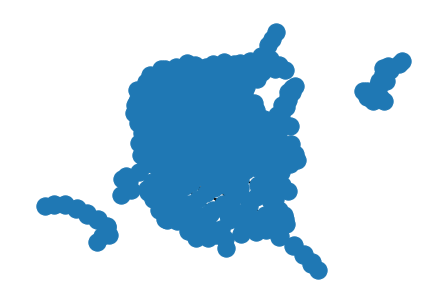

In [205]:
nx.draw(G.subgraph(nodes))

### Map a subgraph

In [206]:
ox.folium.plot_graph_folium(G.subgraph(nodes))

### Map a Subgraph's nodes

In [208]:
# Add nodes
node_list = [[G.nodes.get(node)["y"], G.nodes.get(node)["x"]] for node in nodes]
node_info_list = [{"node_id":node, "neighbors": list(G[node])} for node in nodes]

m = folium.Map()
for i, (node, info) in enumerate(zip(node_list, node_info_list)):
    folium.Marker(node, popup=info).add_to(m)
    
# Add edges
node_list = [{"id": node[0], "y": node[1]["y"], "x": node[1]["x"], "boarding_cost": node[1]["boarding_cost"]} for node in list(G.subgraph(nodes).nodes(data=True))]
node_df = pd.DataFrame(node_list)

edge_df = nx.to_pandas_edgelist(G.subgraph(nodes))
edge_df["color"] = edge_df["mode"].replace("walk", "darkgrey").replace("transit", "blue") # Add edge color

# Add node info
edge_df = edge_df.merge(node_df, left_on="source", right_on="id", how="left")
edge_df = edge_df.merge(node_df, left_on="target", right_on="id", how="left", suffixes=('_source', '_target'))

# Get ready for export to list
edge_df = edge_df[["source", "target", "mode", "name", "osmid", "length", "boarding_cost_source", "y_source", "x_source", "y_target", "x_target", "color"]]

source_list = edge_df[["y_source", "x_source"]].values.tolist()
target_list = edge_df[["y_target", "x_target"]].values.tolist()
popup_list = edge_df[["mode", "osmid", "length", "boarding_cost_source"]].values.tolist()
color_list = edge_df[["color"]].values.tolist()

for i, (source, target, popup, color) in enumerate(zip(source_list, target_list, popup_list, color_list)):
    folium.PolyLine(locations=[source, target], popup=popup, color=color).add_to(m)

In [212]:
m

### Inspect transit nodes with 50m radius

In [213]:
transit_node_list = node_df[node_df["boarding_cost"] > 0].values.tolist()

In [214]:
transit_node_list

[['EZ52N_665', 29.920905, -90.114901, 400.0],
 ['EZ52N_1237', 29.926171, -90.1066, 257.1428571428572],
 ['EZ52N_198', 29.917509, -90.123159, 900.0],
 ['EZ52N_822', 29.930256, -90.116741, 257.1428571428572],
 ['EZ52N_171', 29.916514, -90.115986, 900.0],
 ['EZ52N_836', 29.927836, -90.111572, 276.92307692307696],
 ['EZ52N_1235', 29.926339, -90.104335, 257.1428571428572],
 ['EZ52N_658', 29.920517, -90.112647, 400.0],
 ['EZ52N_313', 29.920233, -90.108137, 400.0],
 ['EZ52N_1629', 29.916659, -90.105901, 900.0],
 ['EZ52N_1559', 29.91638, -90.116389, 900.0],
 ['EZ52N_153', 29.916811, -90.105644, 900.0],
 ['EZ52N_190', 29.916796, -90.120045, 900.0],
 ['EZ52N_648', 29.920682, -90.103733, 400.0],
 ['EZ52N_321', 29.92054, -90.103947, 400.0],
 ['EZ52N_858', 29.926254, -90.104522, 257.1428571428572],
 ['EZ52N_1939', 29.921143, -90.117296, 400.0],
 ['EZ52N_1250', 29.931059, -90.117973, 240.0],
 ['EZ52N_160', 29.916559, -90.113295, 900.0],
 ['EZ52N_695', 29.924031, -90.12633, 400.0],
 ['EZ52N_817', 29.

In [215]:
for node in transit_node_list:
    folium.Circle([node[1], node[2]], radius=50).add_to(m)

In [216]:
m

### Query the transit nodes to know if they'll have a nearest node w/in 50m

In [217]:
sub = G.subgraph(nodes)